<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Cleaning_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import every dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

!pip install -U spacy --quiet
!python -m spacy download en_core_web_md --quiet

import pandas as pd
from PIL import Image
from torchvision import transforms
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

Saving dev_df_country.json to dev_df_country.json
Saving dev_df_dates.json to dev_df_dates.json
Saving dev_df_descr_analyse.json to dev_df_descr_analyse.json
Saving dev_df_lang.json to dev_df_lang.json
Saving train_df_country.json to train_df_country.json
Saving train_df_dates.json to train_df_dates.json
Saving train_df_descr_analyse.json to train_df_descr_analyse.json
Saving train_df_lang.json to train_df_lang.json
Saving trainset_subclass_instance.json to trainset_subclass_instance.json
Saving trainset_subclass_instances_downwards.json to trainset_subclass_instances_downwards.json


In [ ]:
uploaded = files.upload()

Saving dev_df_images.json to dev_df_images.json


# Training set

In [ ]:
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')
validation_df = pd.read_json('dev_df_images.json',orient="records", lines=True)
train_df_subclass = pd.read_json('trainset_subclass_instance.json', orient="records", lines=True)
train_df_subclass_2 = pd.read_json('trainset_subclass_instances_downwards.json',orient = "records", lines = True )
train_df_dates = pd.read_json('train_df_dates.json', orient="records", lines=True)
train_df_lang = pd.read_json('train_df_lang.json', orient="records", lines=True)
train_df_country = pd.read_json('train_df_country.json', orient="records", lines=True)
train_df_descr = pd.read_json('train_df_descr_analyse.json', orient="records", lines=True)

In [ ]:
validation_df.drop(['image'],axis=1,inplace=True)
validation_df.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


## Merge all the datasets

In [ ]:
train_df.columns.to_list()

['item', 'name', 'description', 'type', 'category', 'subcategory', 'label']

In [ ]:
# Get the dataset we first had
initial_df = train_df
initial_variables = train_df.columns.to_list()

# Get the datasets with the features we created
df_to_merge = [train_df_subclass, train_df_dates, train_df_lang, train_df_country, train_df_descr,train_df_subclass_2]

# Merge all of them, in a single dataframe
for df in df_to_merge:
  initial_df = pd.merge(left=initial_df, right=df, on=initial_variables, how='inner')

# Visualisation :
initial_df.head()

,item,name,description,type,category,subcategory,label,subclasses,instances_of,subclass_depth,date,nb_lang,main_country,descr_num_nouns,descr_num_verbs,descr_num_adjectives,descr_has_location,descr_has_ethnic_group,descr_has_event,instances_of_downwards
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,0,1,1,1949.0,126.0,Q298,2,0,1,0,1,0,0
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,0,1,1,1592.0,72.0,Q153136,4,0,1,0,1,0,0
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,0,1,1,165.0,83.0,Q1747689,1,0,1,0,1,0,0
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,0,1,1,1933.0,42.0,Q1041,2,0,1,0,1,0,0
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,0,1,1,1913.0,174.0,Q30,0,0,0,1,0,0,0


# Cleaning

### Type

In [ ]:
# Analysis of the variable 'type'
var = 'type'
initial_df[var].describe()

,type
count,6251
unique,2
top,entity
freq,3924


In [ ]:
# Print the different values for the variable
initial_df[var].unique()

array(['entity', 'concept'], dtype=object)

In [ ]:
# Count the number of NaN
initial_df[var].isna().sum()

np.int64(0)

We convert the variable 'type' to binary so that we can use it in our models.

In [ ]:
# Conversion to binary variable
initial_df['type_cat'] = initial_df['type'].apply(lambda x: 1 if x == 'entity' else 0 if x == 'concept' else None)

### Category

In [ ]:
# Analysis of the variable 'category'
var = 'category'
initial_df[var].describe()

,category
count,6251
unique,19
top,politics
freq,532


In [ ]:
# Print the different values of the variable
initial_df[var].unique()

array(['politics', 'food', 'architecture', 'transportation', 'sports',
       'media', 'philosophy and religion', 'literature', 'visual arts',
       'fashion', 'comics and anime', 'performing arts', 'music', 'films',
       'books', 'history', 'gestures and habits', 'biology', 'geography'],
      dtype=object)

In [ ]:
# Count the number of NaN
initial_df[var].isna().sum()

np.int64(0)

# The statistic test
- Here we would like to test the idea  that even though categories may be correlated with the lables in the  training set it does not have to  necessarly imply a causal relation, but it could occur only  due to the sampling policy bias.
- to test that, we will compare the distribution of the labels in each category for both train set and the dev set. If the there is a causal relation, the distirbution of the labels with respect to the category in both of the sets should not differ significantly on the choosen significance level (assumed p  =0.05)
- Additionaly, we ensure each category has at least 5 items in it , to comply with the assumption about the validity of the chi2 test.

In [ ]:
var = 'category'

checking if both dataframes have the same set of categories

In [ ]:
print(set(initial_df[var].unique()) ==set(validation_df[var].unique()))

True


Ensuring enough items in each category for the chi2 test

In [ ]:
categories_count = validation_df['category'].value_counts()
valid_categories = categories_count[categories_count >= 5].index
print(valid_categories.shape,validation_df['category'].value_counts().shape)
assert(valid_categories.shape[0] == validation_df['category'].value_counts().shape[0])


categories_count = initial_df['category'].value_counts()
categories = categories_count[categories_count >= 5].index
print(categories.shape,initial_df['category'].value_counts().shape)
assert(categories.shape[0] == initial_df['category'].value_counts().shape[0])

(19,) (19,)
(19,) (19,)


### The chi2 test

In [ ]:
res =  []
subcategories = initial_df['category'].unique()
for category in categories:
  train_values = initial_df[initial_df['category'] == category]['label'].value_counts()
  validation_values = validation_df[validation_df['category'] ==category]['label'].value_counts()

  all_labels = sorted(set(train_values.index).union(validation_values.index))
  train_counts = train_values.reindex(all_labels, fill_value=0)
  val_counts = validation_values.reindex(all_labels, fill_value=0)


  contingency_table = [train_counts.values, val_counts.values]

  _, pval, _, _ = chi2_contingency(contingency_table)
  res.append({'category': category,'pval':pval})


# convert to DataFrame
res_df = pd.DataFrame(res)
res_df['not_different'] = res_df['pval'] > 0.05

# Strict p-value assumed 0.02 to avoid the type 2 erro


In [ ]:
res_df['not_different'].value_counts(normalize=False)

,count
not_different,
True,14
False,5


The outcome of the test shows, that  14 out of 19 categories have consistent distirbution in both sets with the p value = 0.05, therefore we could retain  these, and the rest put in the 15th category and only then use the one hot-encoding on the resultant categories

In [ ]:
cols_reject = list(res_df[res_df['not_different'] == False]['category'])
print(cols_reject)

['philosophy and religion', 'history', 'performing arts', 'gestures and habits', 'books']


## Category one hot-encoding

 We map the variable `category` to on-hot encoded  variable, so that we can use it in our models.
 - One hot-encoded is used to inhibit the model from drawing any kind of conclusions based on the ordinal scale i.e if for example, in the ordinal scale,  medicine would be encoded as 1 then biology as 2 and finally the politics as 3 ,that could lead the model to the conclusion that  biology meaning-wise is somwhere between medicine and politics.
 - this operation has it's drawbacks too as it casuses the data sparcity, however this can be remediated later by the operations of feature extraction and feature selection


In [ ]:
var = 'category'
initial_df = pd.get_dummies(initial_df, columns=[var], drop_first=True, dtype = int)
names_to_reject =  [var + '_' + x for x in cols_reject]
initial_df['category_combined'] = initial_df[names_to_reject].any(axis=1)
initial_df.drop(names_to_reject, axis=1, inplace=True)
initial_df.head()

,item,name,description,type,subcategory,label,subclasses,instances_of,subclass_depth,date,...,category_food,category_geography,category_literature,category_media,category_music,category_politics,category_sports,category_transportation,category_visual arts,category_combined
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politician,cultural exclusive,0,1,1,1949.0,...,0,0,0,0,0,1,0,0,0,False
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politician,cultural representative,0,1,1,1592.0,...,0,0,0,0,0,1,0,0,0,False
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politician,cultural representative,0,1,1,165.0,...,0,0,0,0,0,1,0,0,0,False
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politician,cultural representative,0,1,1,1933.0,...,0,0,0,0,0,1,0,0,0,False
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politician,cultural representative,0,1,1,1913.0,...,0,0,0,0,0,1,0,0,0,False


In [ ]:
initial_df.columns

Index(['item', 'name', 'description', 'type', 'subcategory', 'label',
       'subclasses', 'instances_of', 'subclass_depth', 'date', 'nb_lang',
       'main_country', 'descr_num_nouns', 'descr_num_verbs',
       'descr_num_adjectives', 'descr_has_location', 'descr_has_ethnic_group',
       'descr_has_event', 'instances_of_downwards', 'type_cat',
       'category_biology', 'category_comics and anime', 'category_fashion',
       'category_films', 'category_food', 'category_geography',
       'category_literature', 'category_media', 'category_music',
       'category_politics', 'category_sports', 'category_transportation',
       'category_visual arts', 'category_combined'],
      dtype='object')

### Subcategory
- In the case of the subcategory the sparcity would become much more severe in the case of  implementing the one-hot encoding on this variable. Therefore we would like to avoid doing this.
- There could be several reason that could make resonable refraining from doing this operation. First and for all, we might argue that the number of the groups is too numerous, thus the  support of each group is insufficent to draw significant conclusion about it.
- The other argument, that we will try to explore thoroughly , is the fact that there can happen to be no causality between the subcategory of the data and the label. Even if the features would seem to be somehow correlated in case of the training set, it could just  be a biased policy of the data sampling. So to examine this idea we will try to conduct a statistical test,chi2 test again, checking whether there are significant differences in terms of of the distribution of labels grouped by subcategories in the training set and the "dev set"
- But in case there happens to be causality , we would propse encoding the subcategories with the ready embeddings from spacey , to avoid the one-hot encoding sparcity  issue and possibly also to leverage of the relation between the subcategories that will be viible in the embedding space

In [ ]:
var = 'subcategory'
initial_df[var].describe()

,subcategory
count,6251
unique,108
top,politician
freq,99


In [ ]:
initial_df[var].unique()

array(['politician', 'political party', 'government agency', 'law',
       'policy', 'government', 'food', 'drink', 'dish', 'ingredient',
       'cook', 'cooking technique', 'architectural structure',
       'architectural style', 'architect', 'construction', 'building',
       'building material', 'transport company',
       'automobile manufacturer', 'transport', 'mode of transport',
       'station', 'athlete', 'sports team', 'sport', 'sports club',
       'recurring sporting event', 'sports equipment', 'media company',
       'magazine', 'television', 'production company', 'film studio',
       'streaming service', 'philosopher', 'religious leader', 'religion',
       'philosophy', 'philosophical movement', 'religious movement',
       'poetry', 'poet', 'writing style', 'literary genre',
       'literary award', 'writer', 'publisher', 'artist', 'visual arts',
       'art gallery', 'art movement', 'painting', 'photographer',
       'clothing', 'traditional costume', 'designer', 'fas

In [ ]:
print(initial_df[var].unique().shape[0] == validation_df[var].unique().shape[0])

False


## not all subcategories repeat itself

In [ ]:
print(len(set(initial_df[var].unique())))

108


In [ ]:
print(len(set(validation_df[var].unique())))

112


In [ ]:
print(len(set(validation_df[var].unique()).intersection(set(initial_df[var].unique()))))

108


In [ ]:
validation_df.groupby('subcategory')['label'].value_counts(normalize=False)

,,count
subcategory,label,
acting style,cultural exclusive,2
actor,cultural agnostic,3
animal,cultural agnostic,3
animated film,cultural representative,2
animation studio,cultural exclusive,2
...,...,...
tree,cultural agnostic,2
visual arts,cultural agnostic,3
writer,cultural representative,3


In [ ]:
subcategories_count = validation_df['subcategory'].value_counts()
valid_subcategories = subcategories_count[subcategories_count >= 5].index
valid_subcategories.shape

(1,)

In [ ]:
valid_subcategories

Index(['writer'], dtype='object', name='subcategory')

It turns out , that due to small number of items in the validation set - 300, there is only one subcategory where we have at least 5 items, what would make the chi2 square test outcomes not valid, for the remaining all categories. Therefore we can not conduct the test. We will thus encode the subcategories with the embeddings

### embeddings for the subcategories

- The idea that we want to explore now, in order to alleviate the issue of dimensionality explosion in case of one hot encoding of subcategories , are the embeddings.
- We will try to use available embeddings from spacey to try to cluster the subcategories into the groups with high similarity(based on the distance between embeddings in the embedding space) reducing the number of subcategories
- This way we could resolve the issue of data sparcity which would occur if we just one hot encoded every one subcategory of the 112 present in training and validation set. Instead we could group them
- We could also just simply use pre-learned  embeddings  as the mapping for the subcategories, without the clustering of the subcategories, but this would still leave as with high dimensionality(embedding space dimensionality) just for the subcategories columns, not sparse though.

In [ ]:
embeddings = spacy.load("en_core_web_md")

In [ ]:
'''mapping the subcategories to embeddings'''
subcategories = initial_df['subcategory'].unique()
train_vectors = np.array([embeddings(text).vector for text in subcategories])
print(train_vectors)

[[-0.79639    -0.61658    -0.036066   ...  0.51505    -0.40265
  -0.042414  ]
 [-0.803115    0.00581     0.19997498 ... -0.066695    0.047275
   0.55242   ]
 [-0.798885   -0.055735    0.397825   ... -0.18545401  0.23453501
  -0.00815   ]
 ...
 [-0.60877     0.30253    -0.12351    ... -0.096473   -0.46361
  -0.090981  ]
 [-0.80821     0.2348     -0.43378    ... -0.58143     0.20152
   0.37004   ]
 [-0.63153     0.18221     0.31999    ... -0.14954    -0.29755
   0.36043   ]]


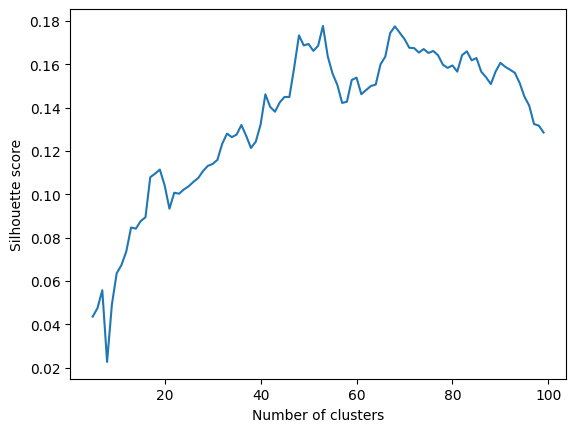

In [ ]:
idx, scores = [], []
potential_number_cluster = range(5,100)
best_score = -1
best_idx = None
for num in potential_number_cluster:
  kmeans = KMeans(n_clusters=num, random_state=0).fit(train_vectors)
  labels = kmeans.labels_
  silhouette_avg = silhouette_score(train_vectors, labels)
  if silhouette_avg > best_score:
    best_score = silhouette_avg
    best_idx = num
  idx.append(num)
  scores.append(silhouette_avg)
plt.plot(idx, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

The clustering does not show very promising scores, the best achieved silhouette score of ~0.18, does not give us a very big intra-cluster similarity and big inter-cluster dissimilarity, therefore it is not possible to combine the subcategories into the cluster in  a meaningful way. Thus the issue of very high dimensionality remains and due to this we  decide to drop the subcategory column and not use it for our feature based neural network model.

In [ ]:
initial_df.drop('subcategory', axis=1, inplace=True)

### Labels

In [ ]:
# Analysis of the labels
initial_df['label'].describe()

,label
count,6244
unique,9
top,cultural exclusive
freq,2685


In [ ]:
# Print the different labels
initial_df['label'].unique()

array(['cultural exclusive', 'cultural representative',
       'cultural agnostic', 'cultural', 'cult', nan, 'cultural agn',
       'cultural represent', 'cultural ex', 'cultural ag'], dtype=object)

In [ ]:
# Print the frequency of appearance of labels
initial_df[['item', 'label']].groupby("label").count()

,item
label,
cult,1
cultural,5
cultural ag,1
cultural agn,3
cultural agnostic,1862
cultural ex,1
cultural exclusive,2685
cultural represent,1
cultural representative,1685


We are suppose to have only 3 different labels

- Cultural Exclusive (C.E.)
- Cultural Agnostic (C.A.)
- Cultural Representative (C.R.)

Instead, we have seen that there are 9 different labels in the dataset, plus some NaN. So we have to clean the data, in order to get only 3 differents labels. Here is the solution we propose :

First step :

We distinguish the 3 labels we want (C.A., C.E., C.R.) and also labels that are close enough  that without a shade of doubt we map them to proper ones('Cultural agn', 'cultural represent', 'cultural ex', 'cultural ag'). So we propose the following mapping :

- 'cultural agn' : C.A.
- 'cultural represent' : C.R.
- 'cultural ex' : C.E.
- 'cultural ag' : C.A.

Second step :

For the other labels ('cultural', 'cult', nan), we propose to apply the rule that was define to build the dataset (see https://huggingface.co/datasets/sapienzanlp/nlp2025_hw1_cultural_dataset) : Ask ChatGPT-o3 !

First step :

In [ ]:
# Select the labels and associated labels to correct
to_correct = initial_df[initial_df["label"].isin(['cultural agn','cultural represent', 'cultural ex', 'cultural ag'])][['item', 'label']]
to_correct

,item,label
1545,http://www.wikidata.org/entity/Q86135347,cultural agn
3698,http://www.wikidata.org/entity/Q509900,cultural represent
4391,http://www.wikidata.org/entity/Q643677,cultural ex
4819,http://www.wikidata.org/entity/Q1711593,cultural agn
5731,http://www.wikidata.org/entity/Q25618,cultural ag
5968,http://www.wikidata.org/entity/Q30405,cultural agn


In [ ]:
# Create the mapping for correction
mapping_correction = {
  'cultural agn' : 'cultural agnostic',
  'cultural represent' : 'cultural representative',
  'cultural ex' : 'cultural exclusive',
  'cultural ag' : 'cultural agnostic'
}

In [ ]:
# Apply the correction
to_correct['label'] = to_correct['label'].map(mapping_correction)

In [ ]:
# We update the transformations to the initial dataset
initial_df.set_index('item', inplace=True)
to_correct.set_index('item', inplace=True)

initial_df.update(to_correct)
initial_df.reset_index(inplace=True)


# We check if the updates are corrects
initial_df[1543:1547]

,item,name,description,type,label,subclasses,instances_of,subclass_depth,date,nb_lang,...,category_food,category_geography,category_literature,category_media,category_music,category_politics,category_sports,category_transportation,category_visual arts,category_combined
1543,http://www.wikidata.org/entity/Q27503001,professional athlete,person who earns their living from sports,concept,cultural agnostic,0,1,9,NaN,17.0,...,0,0,0,0,0,0,1,0,0,False
1544,http://www.wikidata.org/entity/Q107690317,competition climber,climber who competes in IFSC and Olympic climb...,concept,cultural agnostic,0,3,9,NaN,14.0,...,0,0,0,0,0,0,1,0,0,False
1545,http://www.wikidata.org/entity/Q86135347,climber,person who practices climbing,concept,cultural agnostic,2,1,9,NaN,16.0,...,0,0,0,0,0,0,1,0,0,False
1546,http://www.wikidata.org/entity/Q28971125,cheerleader,performer who leads crowd support at sports ev...,concept,cultural representative,0,1,9,NaN,33.0,...,0,0,0,0,0,0,1,0,0,False


Second step :

Here are the items that ChatGPT will have to classify :

In [ ]:
# Select the items that have no label, or with label 'cultural', or 'cult'
to_classify = initial_df[(initial_df["label"].isin(["cultural", "cult"])) | (initial_df["label"].isna())][['item', 'name', 'description']]
to_classify

,item,name,description
858,http://www.wikidata.org/entity/Q957033,Sunny Baudelaire,fictional character
1066,http://www.wikidata.org/entity/Q30327019,post and lintel,building system where horizontal elements (bea...
1214,http://www.wikidata.org/entity/Q811361,architectural glass,building material typically used as transparen...
1651,http://www.wikidata.org/entity/Q12014207,trekking,backpacking or hiking
2556,http://www.wikidata.org/entity/Q257907,Ethiopian movement,religious movement in southern Africa
2831,http://www.wikidata.org/entity/Q1136336,Costa Book Awards,annual series of literary awards in five categ...
3236,http://www.wikidata.org/entity/Q67111,Franz Pfemfert,German journalist (1879-1954)
3820,http://www.wikidata.org/entity/Q1089672,The Elm-Chanted Forest,1986 animated film directed by Milan Blažeković
4853,http://www.wikidata.org/entity/Q85755629,Daniel Airlie,novel
5566,http://www.wikidata.org/entity/Q206912,extremophile,organisms specifically adapted to live and sur...


Here is the result for chatgpt :

In [ ]:
# Create the dictionnary for the mapping
categories = {
    'http://www.wikidata.org/entity/Q957033': 'cultural representative',
    'http://www.wikidata.org/entity/Q30327019': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q811361': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q12014207': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q257907': 'cultural exclusive',
    'http://www.wikidata.org/entity/Q1136336': 'cultural representative',
    'http://www.wikidata.org/entity/Q67111': 'cultural representative',
    'http://www.wikidata.org/entity/Q1089672': 'cultural representative',
    'http://www.wikidata.org/entity/Q85755629': 'cultural representative',
    'http://www.wikidata.org/entity/Q206912': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q23228': 'cultural agnostic',
    'http://www.wikidata.org/entity/Q3196604': 'cultural representative',
    'http://www.wikidata.org/entity/Q1940624': 'cultural representative'
}

# Apply the classification
to_classify['label'] = to_classify['item'].map(categories)

In [ ]:
# We update the transformations to the initial dataset
initial_df.set_index('item', inplace=True)
to_classify.set_index('item', inplace=True)

initial_df.update(to_classify)
initial_df.reset_index(inplace=True)


# We check if the updates are corrects
initial_df[856:860]

,item,name,description,type,label,subclasses,instances_of,subclass_depth,date,nb_lang,...,category_food,category_geography,category_literature,category_media,category_music,category_politics,category_sports,category_transportation,category_visual arts,category_combined
856,http://www.wikidata.org/entity/Q929866,Santi Santamaria,Spanish chef (1957–2011),entity,cultural exclusive,0,1,1,1957.0,41.0,...,1,0,0,0,0,0,0,0,0,False
857,http://www.wikidata.org/entity/Q899011,Ian Beale,fictional character from the soap opera EastEn...,entity,cultural exclusive,0,2,1,1968.0,8.0,...,1,0,0,0,0,0,0,0,0,False
858,http://www.wikidata.org/entity/Q957033,Sunny Baudelaire,fictional character,entity,cultural representative,0,4,1,NaN,16.0,...,1,0,0,0,0,0,0,0,0,False
859,http://www.wikidata.org/entity/Q935079,SpongeBob SquarePants,main character from the animated television sh...,entity,cultural representative,0,4,1,1986.0,55.0,...,1,0,0,0,0,0,0,0,0,False


Check if everything is proper now :

In [ ]:
# Verify if the mapping worked
initial_df['label'].describe()

,label
count,6251
unique,3
top,cultural exclusive
freq,2687


In [ ]:
initial_df['label'].unique()

array(['cultural exclusive', 'cultural representative',
       'cultural agnostic'], dtype=object)

In [ ]:
initial_df[['item', 'label']].groupby("label").count()

,item
label,
cultural agnostic,1871
cultural exclusive,2687
cultural representative,1693


In [ ]:
initial_df.columns

Index(['item', 'name', 'description', 'type', 'label', 'subclasses',
       'instances_of', 'subclass_depth', 'date', 'nb_lang', 'main_country',
       'descr_num_nouns', 'descr_num_verbs', 'descr_num_adjectives',
       'descr_has_location', 'descr_has_ethnic_group', 'descr_has_event',
       'instances_of_downwards', 'type_cat', 'category_biology',
       'category_comics and anime', 'category_fashion', 'category_films',
       'category_food', 'category_geography', 'category_literature',
       'category_media', 'category_music', 'category_politics',
       'category_sports', 'category_transportation', 'category_visual arts',
       'category_combined'],
      dtype='object')

### Dates

In [ ]:
# Analysis of the variable 'date'
var = 'date'
initial_df[var].describe(include='category')

,date
count,2506.000000
mean,1880.424980
std,258.087493
min,1.000000
25%,1892.000000
50%,1948.000000
75%,1983.000000
max,5000.000000


In [ ]:
# Number of missing values
initial_df[var].isna().sum()

np.int64(3745)

In [ ]:
# Conversion to integers
initial_df[var] = initial_df[var].astype('Int64')

feasibility check

In [ ]:
# Look for non credible values
initial_df[initial_df[var] > 2025].shape[0]

2

In [ ]:
# Get the number or different values in the variable 'date'
initial_df[var].nunique()

446

Problems :

- Faulty values happening i.e values bigger than 2025 (current year) Not possible : Set it to Nan
- Lot of missing values : Same arguments as for the photos, we fill in with the date -1 : Hope that the model will learn to recognize item with no dates. Interpret the fact that the absence of dates for an item can be correlated to its label


Max values

In [ ]:
# Modify the non credible dates
current_year = int(2025)
initial_df['date'] = initial_df['date'].apply(lambda x: None if x > current_year else x)

Missing values

In [ ]:
# Fill in the NaN values with -1
initial_df['date'] = initial_df['date'].fillna(-1)

### Nb_lang

In [ ]:
# Analysis of the variable 'nb_lang'
var = 'nb_lang'
initial_df[var].describe(include='category')

,nb_lang
count,6250.000000
mean,31.190240
std,36.651012
min,1.000000
25%,8.000000
50%,19.000000
75%,39.000000
max,310.000000


In [ ]:
# Number of missing values
initial_df[var].isna().sum()

np.int64(1)

In [ ]:
# Number of different values
initial_df[var].nunique()

219

Problem : We have 1 missing value

In [ ]:
initial_df[initial_df[var].isna()]

,item,name,description,type,label,subclasses,instances_of,subclass_depth,date,nb_lang,...,category_food,category_geography,category_literature,category_media,category_music,category_politics,category_sports,category_transportation,category_visual arts,category_combined
2058,http://www.wikidata.org/entity/Q7551241,social media and television,Emerging platforms,entity,cultural agnostic,0,2,1,-1.0,NaN,...,0,0,0,1,0,0,0,0,0,False


Since it is just one value, we could just use a median

In [ ]:
# filling the nan case
med_value = np.median(initial_df['nb_lang'])
initial_df['nb_lang'] = initial_df['nb_lang'].fillna(med_value)

### Country/nationality information

Here are the information that we have scraped from the wikidata, refering to the claims of: country of origin, nationality of origin, country

- We will create another column in our dataset which will describe whether the entity is having any country of origin, or if it is just a missing value.
- We are not interested in the specific countries as this could be just inherent bias of the data we are given, but just of  the existence or noexistence of the relation entity-country, as it may be a good predictor for cultural exlusivenes/representativeness or agnosticity

In [ ]:
# Analysis
var = 'main_country'
initial_df[var].describe()

,main_country
count,3384
unique,283
top,Q30
freq,580


In [ ]:
# Check the number of missing values
initial_df[var].isna().sum()

np.int64(2867)

In [ ]:
# Number of different values
initial_df[var].nunique()

283

Here

- Solution (what we will do) : 0 if NaN, 1 otherwise. Because in this case we are only interested in the fact whether the entity is connected with a country or not, we are not interested in the specific country as it is just a particular  realisation of the relation - has country/nationality of origin

In [ ]:
# application of one hot encoding
initial_df['main_country_cat'] = initial_df['main_country'].apply(lambda x: 0 if pd.isna(x) else 1)

### Sparqle features
- Here we check if everything is alright with the features we have scraped with the sparqle library.

In [ ]:
initial_df.columns

Index(['item', 'name', 'description', 'type', 'label', 'subclasses',
       'instances_of', 'subclass_depth', 'date', 'nb_lang', 'main_country',
       'descr_num_nouns', 'descr_num_verbs', 'descr_num_adjectives',
       'descr_has_location', 'descr_has_ethnic_group', 'descr_has_event',
       'instances_of_downwards', 'type_cat', 'category_biology',
       'category_comics and anime', 'category_fashion', 'category_films',
       'category_food', 'category_geography', 'category_literature',
       'category_media', 'category_music', 'category_politics',
       'category_sports', 'category_transportation', 'category_visual arts',
       'category_combined', 'main_country_cat'],
      dtype='object')

### The sparqle  variables:
- instance_of
- instance_of_downwards
- subclass_depth
- subclass_depth

### Instances of downwards
This variable shows how many, distinct from the given entity, entities there are on the wikidata that are an instance of the given entity

<Axes: ylabel='instances_of_downwards'>

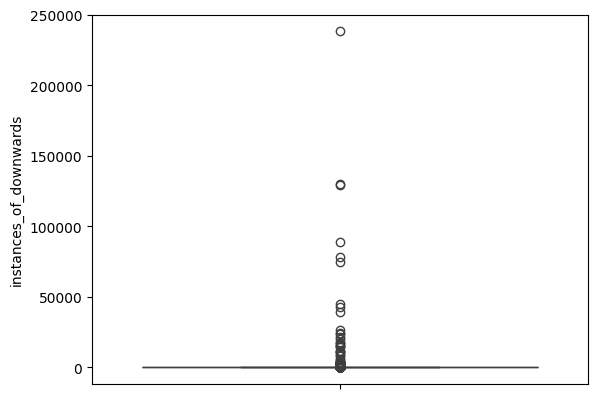

In [ ]:
sns.boxplot(initial_df['instances_of_downwards'])

In [ ]:
initial_df['instances_of_downwards'].describe()

,instances_of_downwards
count,6251.000000
mean,202.772836
std,4387.405625
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,238283.000000


checking the distirbution of the variable

In [ ]:
print(initial_df['instances_of_downwards'].describe(percentiles=[i/100 for i in range(1, 100)]))

count      6251.000000
mean        202.772836
std        4387.405625
min           0.000000
1%            0.000000
             ...      
96%          48.000000
97%         102.500000
98%         216.000000
99%         783.000000
max      238283.000000
Name: instances_of_downwards, Length: 104, dtype: float64


As we see from the boxplot above and the description of the data also above, the majority of the entries is 0, in fact more than 75 % since , 75 percentile is still 0, apart from that there are also extreme outliers, like the maximal value being 238238 which is only 1 percentile and it is 3 orders of magnitued bigger than vaalues below 99 percentile. Therefore we clipat the  99 percentile.

In [ ]:
initial_df['instances_of_downwards'] = initial_df['instances_of_downwards'].clip(upper=initial_df['instances_of_downwards'].quantile(0.99))

In [ ]:
print(initial_df['instances_of_downwards'].describe(percentiles=[i/100 for i in range(1, 100)]))

count    6251.000000
mean       15.565190
std        91.705845
min         0.000000
1%          0.000000
            ...     
96%        48.000000
97%       102.500000
98%       216.000000
99%       767.000000
max       783.000000
Name: instances_of_downwards, Length: 104, dtype: float64


### instances of
- do not know the interpretation of this myself

In [ ]:
initial_df['instances_of'].isna().sum()

np.int64(0)

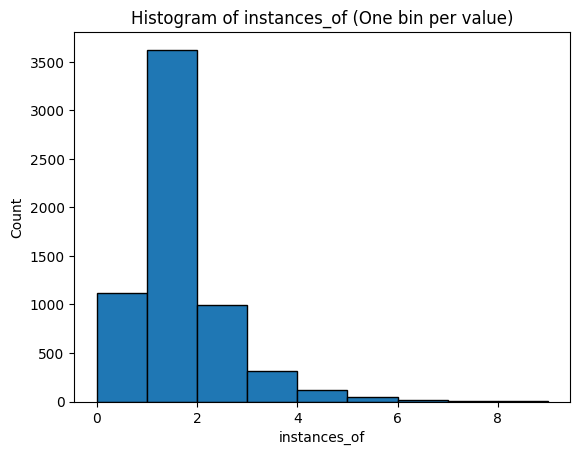

In [ ]:
bin_edges = range(initial_df['instances_of'].min(), initial_df['instances_of'].max() + 1)
plt.hist(initial_df['instances_of'], bins=bin_edges, edgecolor='black')
plt.xlabel('instances_of')
plt.ylabel('Count')
plt.title('Histogram of instances_of (One bin per value)')
plt.show()

In [ ]:
initial_df.groupby('instances_of')['label'].value_counts(normalize=False)

instances_of  label                  
0             cultural agnostic           664
              cultural exclusive          289
              cultural representative     169
1             cultural exclusive         1617
              cultural representative    1158
              cultural agnostic           850
2             cultural exclusive          491
              cultural agnostic           259
              cultural representative     247
3             cultural exclusive          166
              cultural representative      76
              cultural agnostic            74
4             cultural exclusive           83
              cultural representative      22
              cultural agnostic            16
5             cultural exclusive           23
              cultural representative      15
              cultural agnostic             5
6             cultural exclusive            7
              cultural agnostic             3
              cultural representative       3
7             cultural exclusive            8
              cultural representative       1
8             cultural exclusive            1
9             cultural exclusive            2
              cultural representative       2
Name: count, dtype: int64

No missing values or no outliers either, but the data gets extremly sparse above 5 , so we introduce the clipping  -  upper bound being 5

In [ ]:
initial_df['instances_of'] = initial_df['instances_of_downwards'].clip(upper=5)

In [ ]:
initial_df.groupby('instances_of')['label'].value_counts(normalize=False)

instances_of  label                  
0             cultural exclusive         2481
              cultural representative    1523
              cultural agnostic          1141
1             cultural agnostic           149
              cultural exclusive           58
              cultural representative      55
2             cultural agnostic            81
              cultural representative      23
              cultural exclusive           20
3             cultural agnostic            35
              cultural representative      13
              cultural exclusive            9
4             cultural agnostic            35
              cultural exclusive            9
              cultural representative       3
5             cultural agnostic           430
              cultural exclusive          110
              cultural representative      76
Name: count, dtype: int64

### The subclasses

In [ ]:
initial_df['subclasses'].isna().sum()

np.int64(0)

In [ ]:
initial_df['subclasses'].describe()

,subclasses
count,6251.000000
mean,2.773796
std,19.472812
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,621.000000


In [ ]:
print(initial_df['subclasses'].describe(percentiles=[i/100 for i in range(1, 100)]))

count    6251.000000
mean        2.773796
std        19.472812
min         0.000000
1%          0.000000
            ...     
96%        13.000000
97%        19.000000
98%        27.000000
99%        56.000000
max       621.000000
Name: subclasses, Length: 104, dtype: float64


the same case as for the instances_of , extreme outliers in the last percentile. which will be clipped.

In [ ]:
initial_df['subclasses'] = initial_df['subclasses'].clip(upper=initial_df['subclasses'].quantile(0.99))

In [ ]:
print(initial_df['subclasses'].describe(percentiles=[i/100 for i in range(1, 100)]))

count    6251.000000
mean        1.859223
std         7.416027
min         0.000000
1%          0.000000
            ...     
96%        13.000000
97%        19.000000
98%        27.000000
99%        56.000000
max        56.000000
Name: subclasses, Length: 104, dtype: float64


### subclass depth

- how many levels of subclasses are "below" the given entity in thee wikidata relationship graph

In [ ]:
initial_df['subclass_depth'].isna().sum()

np.int64(0)

In [ ]:
initial_df['subclass_depth'].describe()

,subclass_depth
count,6251.000000
mean,3.854103
std,3.303112
min,1.000000
25%,1.000000
50%,1.000000
75%,7.000000
max,15.000000


In [ ]:
print(initial_df['subclass_depth'].describe(percentiles=[i/100 for i in range(1, 100)]))

count    6251.000000
mean        3.854103
std         3.303112
min         1.000000
1%          1.000000
            ...     
96%        10.000000
97%        10.000000
98%        11.000000
99%        11.000000
max        15.000000
Name: subclass_depth, Length: 104, dtype: float64


Potentially above the 99 percentile could be clipped as it is 1 std, from the 99 percentile

In [ ]:
(initial_df['subclass_depth'] > 11).mean()


initial_df[initial_df['subclass_depth'] > 11]['label'].value_counts(normalize=True)

,proportion
label,
cultural exclusive,0.482143
cultural representative,0.392857
cultural agnostic,0.125000


The number of the entities with depth > 11

In [ ]:
initial_df[initial_df['subclass_depth'] > 11].shape[0]

56

Comapring the labels distirbution between the tail with the outliers and 97-99 precentile.

In [ ]:
initial_df[(initial_df['subclass_depth'] <= 11) & (initial_df['subclass_depth'] >= 10)]['label'].value_counts(normalize=True)

,proportion
label,
cultural agnostic,0.418239
cultural representative,0.301887
cultural exclusive,0.279874


Since the difference in distribution of the labels with respect to subclass depth between 97-99 percentile and for the "outliers" values of sublcass depth are different we decide not to clip it.

## Exportation

In [ ]:
# Visualisation
initial_df

,item,name,description,type,label,subclasses,instances_of,subclass_depth,date,nb_lang,...,category_geography,category_literature,category_media,category_music,category_politics,category_sports,category_transportation,category_visual arts,category_combined,main_country_cat
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,cultural exclusive,0,0,1,1949.0,126.0,...,0,0,0,0,1,0,0,0,False,1
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,cultural representative,0,0,1,1592.0,72.0,...,0,0,0,0,1,0,0,0,False,1
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,cultural representative,0,0,1,165.0,83.0,...,0,0,0,0,1,0,0,0,False,1
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,cultural representative,0,0,1,1933.0,42.0,...,0,0,0,0,1,0,0,0,False,1
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,cultural representative,0,0,1,1913.0,174.0,...,0,0,0,0,1,0,0,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,http://www.wikidata.org/entity/Q321103,Bühl,"quarter of Tübingen, Baden-Württemberg, Germany",entity,cultural exclusive,0,0,1,-1.0,73.0,...,1,0,0,0,0,0,0,0,False,1
6247,http://www.wikidata.org/entity/Q338167,Tenderloin,area of New York City during the late 19th and...,entity,cultural exclusive,0,0,1,-1.0,9.0,...,1,0,0,0,0,0,0,0,False,1
6248,http://www.wikidata.org/entity/Q66991,Schinznach-Dorf,former municipality and current district of Sc...,entity,cultural exclusive,0,0,1,-1.0,30.0,...,1,0,0,0,0,0,0,0,False,1
6249,http://www.wikidata.org/entity/Q66922,Ependes,village and former municipality in Bois-d'Amon...,entity,cultural exclusive,0,0,1,-1.0,82.0,...,1,0,0,0,0,0,0,0,False,1


In [ ]:
#initial_df.to_json('final_train_df.json', orient="records", lines=True)
#files.download('final_train_df.json')
initial_df.to_json('train_df_complete.json', orient='records', lines=True)

# Here to conduct operations on the Dev set

In [ ]:
dev_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

dev_df_subclass = pd.read_json('devset_subclass_instance.json', orient="records", lines=True)
dev_df_images = pd.read_json('dev_df_images.json', orient="records", lines=True)
dev_df_dates = pd.read_json('dev_df_dates.json', orient="records", lines=True)
dev_df_lang = pd.read_json('dev_df_lang.json', orient="records", lines=True)
dev_df_country = pd.read_json('dev_df_country.json', orient="records", lines=True)
dev_df_descr = pd.read_json('dev_df_descr_analyse.json', orient="records", lines=True)

## Merge all the datasets

In [ ]:
dev_df.columns.to_list()

['item', 'name', 'description', 'type', 'category', 'subcategory', 'label']

In [ ]:
# Get the dataset we first had
initial_dev_df = dev_df
initial_variables = dev_df.columns.to_list()

# Get the datasets with the features we created
df_to_merge = [dev_df_subclass, dev_df_images, dev_df_dates, dev_df_lang, dev_df_country, dev_df_descr]

# Merge all of them, in a single dataframe
for df in df_to_merge:
  initial_dev_df = pd.merge(left=initial_dev_df, right=df, on=initial_variables, how='inner')

# Visualisation :
initial_dev_df.head()

,item,name,description,type,category,subcategory,label,subclasses,instances_of,subclass_depth,image,date,nb_lang,main_country,descr_num_nouns,descr_num_verbs,descr_num_adjectives,descr_has_location,descr_has_ethnic_group,descr_has_event
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,0,1,1,"[[[85, 93, 69], [64, 70, 47], [50, 55, 39], [1...",1949.0,126.0,Q298,2,0,1,0,1,0
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,0,1,1,"[[[33, 31, 17], [35, 33, 19], [32, 31, 19], [2...",1592.0,72.0,Q153136,4,0,1,0,1,0
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,0,1,1,"[[[109, 110, 103], [113, 115, 107], [117, 118,...",165.0,83.0,Q1747689,1,0,1,0,1,0
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,0,1,1,"[[[136, 91, 41], [123, 74, 26], [169, 134, 89]...",1933.0,42.0,Q1041,2,0,1,0,1,0
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,0,1,1,"[[[106, 88, 76], [114, 96, 84], [115, 96, 84],...",1913.0,174.0,Q30,0,0,0,1,0,0


## Cleaning

### Type

We convert the variable 'type' to binary so that we can use it in our models.

In [ ]:
initial_dev_df['type_cat'] = initial_dev_df['type'].apply(lambda x: 1 if x == 'entity' else 0 if x == 'concept' else None)

In [ ]:
initial_dev_df['subcategory'].isna().sum()

### Category

We map the variable 'category' to multimodal variable, so that we can use it in our models.

In [ ]:
initial_dev_df["category_cat"] = initial_dev_df['category'].map(mapping_category)

NameError: name 'mapping_category' is not defined

In [ ]:
initial_dev_df['subcategory'].isna().sum()

### Subcategory

We map the variable 'category' to multimodal variable, so that we can use it in our models.

In [ ]:
initial_dev_df["subcategory_cat"] = initial_dev_df['subcategory'].map(mapping_subcategory)

politician : 0
political party : 1
government agency : 2
law : 3
policy : 4
government : 5
food : 6
drink : 7
dish : 8
ingredient : 9
cook : 10
cooking technique : 11
architectural structure : 12
architectural style : 13
architect : 14
construction : 15
building : 16
building material : 17
transport company : 18
automobile manufacturer : 19
transport : 20
mode of transport : 21
station : 22
athlete : 23
sports team : 24
sport : 25
sports club : 26
recurring sporting event : 27
sports equipment : 28
media company : 29
magazine : 30
television : 31
production company : 32
film studio : 33
streaming service : 34
philosopher : 35
religious leader : 36
religion : 37
philosophy : 38
philosophical movement : 39
religious movement : 40
poetry : 41
poet : 42
writing style : 43
literary genre : 44
literary award : 45
writer : 46
publisher : 47
artist : 48
visual arts : 49
art gallery : 50
art movement : 51
painting : 52
photographer : 53
clothing : 54
traditional costume : 55
designer : 56
fashi

In [ ]:
initial_dev_df['subcategory'].isna().sum()

### Images

Here, we have a lot of missing values, so we fill in the missing values with white images, in order to

- Hope that the model will learn to recognize and ignore thoses white images
- Interpret the fact that the absence of image for an item can be correlated to its label
- Regularization with noise

In [ ]:
def fill_NaN_image(image):

  """
  If a cell is empty, it fills in with a white image, of dimension (28,28,3) ie (height, width, channels)
  """

  if image is None or (isinstance(image, float) and np.isnan(image)):
    image = np.ones((28, 28, 3), dtype=np.uint8) * 255

  return image

In [ ]:
initial_dev_df['image'] = initial_dev_df['image'].apply(lambda x: fill_NaN_image(x))

In [ ]:
initial_dev_df

,item,name,description,type,category,subcategory,label,subclasses,instances_of,subclass_depth,image,date,nb_lang,main_country,descr_num_nouns,descr_num_verbs,descr_num_adjectives,descr_has_location,descr_has_ethnic_group,descr_has_event
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,0,1,1,"[[[85, 93, 69], [64, 70, 47], [50, 55, 39], [1...",1949.0,126.0,Q298,2,0,1,0,1,0
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,0,1,1,"[[[33, 31, 17], [35, 33, 19], [32, 31, 19], [2...",1592.0,72.0,Q153136,4,0,1,0,1,0
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,0,1,1,"[[[109, 110, 103], [113, 115, 107], [117, 118,...",165.0,83.0,Q1747689,1,0,1,0,1,0
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,0,1,1,"[[[136, 91, 41], [123, 74, 26], [169, 134, 89]...",1933.0,42.0,Q1041,2,0,1,0,1,0
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,0,1,1,"[[[106, 88, 76], [114, 96, 84], [115, 96, 84],...",1913.0,174.0,Q30,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,http://www.wikidata.org/entity/Q321103,Bühl,"quarter of Tübingen, Baden-Württemberg, Germany",entity,geography,neighborhood,cultural exclusive,0,2,1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",NaN,73.0,Q183,1,0,0,1,0,0
6247,http://www.wikidata.org/entity/Q338167,Tenderloin,area of New York City during the late 19th and...,entity,geography,neighborhood,cultural exclusive,0,1,1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",NaN,9.0,Q30,3,0,3,1,0,0
6248,http://www.wikidata.org/entity/Q66991,Schinznach-Dorf,former municipality and current district of Sc...,entity,geography,neighborhood,cultural exclusive,0,3,1,"[[[61, 117, 223], [64, 118, 226], [65, 119, 22...",NaN,30.0,Q39,2,0,2,1,0,0
6249,http://www.wikidata.org/entity/Q66922,Ependes,village and former municipality in Bois-d'Amon...,entity,geography,neighborhood,cultural exclusive,0,2,1,"[[[153, 147, 44], [209, 198, 54], [201, 192, 5...",NaN,82.0,Q39,2,0,1,1,0,0


### Dates

Max values

In [ ]:
current_year = int(2025)
initial_dev_df['date'] = initial_dev_df['date'].apply(lambda x: None if x > current_year else x)

Missing values

In [ ]:
initial_dev_df['date'] = initial_dev_df['date'].fillna(-1)

### Nb_lang

In [ ]:
med_value = initial_dev_df['nb_lang'].median()
initial_dev_df['nb_lang'] = initial_dev_df['nb_lang'].fillna(int(med_value))

### Main country

In [ ]:
initial_dev_df['main_country_cat'] = initial_dev_df['main_country'].apply(lambda x: 0 if pd.isna(x) else 1)

## Exportation

In [ ]:
# Visualisation

initial_dev_df

,item,name,description,type,category,subcategory,label,subclasses,instances_of,subclass_depth,...,date,nb_lang,main_country,descr_num_nouns,descr_num_verbs,descr_num_adjectives,descr_has_location,descr_has_ethnic_group,descr_has_event,main_country_cat
0,http://www.wikidata.org/entity/Q306,Sebastián Piñera,Chilean entrepreneur and politician (1949–2024),entity,politics,politician,cultural exclusive,0,1,1,...,1949.0,126.0,Q298,2,0,1,0,1,0,1
1,http://www.wikidata.org/entity/Q12735,John Amos Comenius,"Czech teacher, educator, philosopher and write...",entity,politics,politician,cultural representative,0,1,1,...,1592.0,72.0,Q153136,4,0,1,0,1,0,1
2,http://www.wikidata.org/entity/Q1752,Macrinus,Roman emperor from 217 to 218,entity,politics,politician,cultural representative,0,1,1,...,165.0,83.0,Q1747689,1,0,1,0,1,0,1
3,http://www.wikidata.org/entity/Q1639,Lamine Diack,Senegalese sports manager (1933–2021),entity,politics,politician,cultural representative,0,1,1,...,1933.0,42.0,Q1041,2,0,1,0,1,0,1
4,http://www.wikidata.org/entity/Q9588,Richard Nixon,President of the United States from 1969 to 1974,entity,politics,politician,cultural representative,0,1,1,...,1913.0,174.0,Q30,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,http://www.wikidata.org/entity/Q321103,Bühl,"quarter of Tübingen, Baden-Württemberg, Germany",entity,geography,neighborhood,cultural exclusive,0,2,1,...,-1.0,73.0,Q183,1,0,0,1,0,0,1
6247,http://www.wikidata.org/entity/Q338167,Tenderloin,area of New York City during the late 19th and...,entity,geography,neighborhood,cultural exclusive,0,1,1,...,-1.0,9.0,Q30,3,0,3,1,0,0,1
6248,http://www.wikidata.org/entity/Q66991,Schinznach-Dorf,former municipality and current district of Sc...,entity,geography,neighborhood,cultural exclusive,0,3,1,...,-1.0,30.0,Q39,2,0,2,1,0,0,1
6249,http://www.wikidata.org/entity/Q66922,Ependes,village and former municipality in Bois-d'Amon...,entity,geography,neighborhood,cultural exclusive,0,2,1,...,-1.0,82.0,Q39,2,0,1,1,0,0,1


In [ ]:
#initial_devdf.to_json('final_dev_df.json', orient="records", lines=True)
#files.download('final_dev_df.json')